In [22]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
from astropy import units as u
from scipy.optimize import minimize
from scipy.stats import linregress
print astropy.__version__
import math
import emcee
import corner

import matplotlib 
%matplotlib notebook

from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

import winsound

import time

winsound.Beep(440,1500)

2.0.2


In [2]:
class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}

class arcoiris_merged_spectrum(object):
    
    def __init__(self, name, data, date):
        self.objectname = name
        self.obsdate = date
        
        tempwav = []
        tempflux = []
        temperr = []
        #tempsnr = []
        
        for line in data:
            conts = line.split()
            tempwav.append(float(conts[0]))
            tempflux.append(float(conts[1]))
            temperr.append(float(conts[2]))
            
        self.wav = np.array(tempwav)
        self.flux = np.array(tempflux)
        self.err = np.array(temperr)
        self.snr = self.flux/self.err
        
        self.flux_watts = self.flux*10.
        self.err_watts = self.err*10.
        
    def __str__(self):
        s = 'Wav Flux Err \n'
        for i in range(self.wav.size):
            s = s + str(self.wav[i]) + ' ' + str(self.flux[i]) + ' ' + str(self.err[i]) + '\n'
            
        return s
    
    def get_snr_cut_spectrum(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
    
    def get_snr_cut_spectrum_watts(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
        
        
class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return
    
class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig


In [3]:
def import_arcoiris_from_text(filename, name, date):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_merged_spectrum(name, data, date)
    
    return spectrum

def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum

In [4]:
def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum

In [5]:
awi0005x3s_20171104_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_remerged.txt','AWI0005x3s','2017-11-04')
awi0005x3s_20180301_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180301_remerged.txt','AWI0005x3s','2018-03-01')
awi0005x3s_20180302_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180302_remerged.txt','AWI0005x3s','2018-03-02')

awi0005x3s_20171104_2massweighted_merged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_2massweighted_merged.txt','AWI0005x3s','2017-11-04')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

First row found: 47


In [6]:
awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts, awi0005x3s_20171104_highsnr_err = awi0005x3s_20171104_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts, awi0005x3s_20180301_highsnr_err = awi0005x3s_20180301_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts, awi0005x3s_20180302_highsnr_err = awi0005x3s_20180302_remerged.get_snr_cut_spectrum_watts(20.)

awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts, awi0005x3s_20171104_2mass_highsnr_err = awi0005x3s_20171104_2massweighted_merged.get_snr_cut_spectrum_watts(20.)


<IPython.core.display.Javascript object>


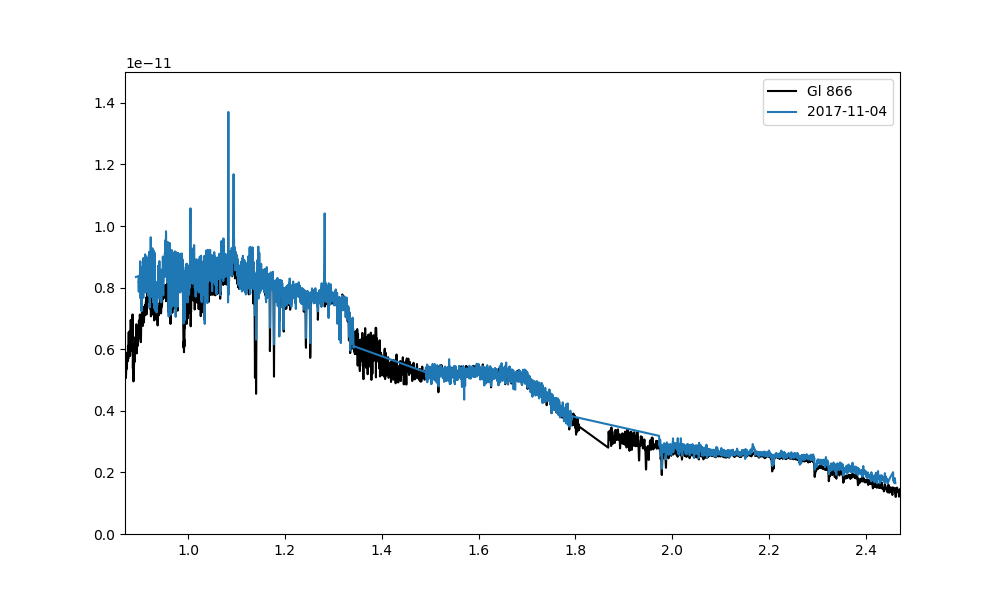

In [7]:
plt.figure(figsize=(10.,6.))

plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts/0.00245,label='2017-11-04')
#plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts*380.,label='2018-03-01')
#plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts*410.,label='2018-03-02')

wav_20171104_angstroms = awi0005x3s_20171104_highsnr_wav*10000.
wav_20180301_angstroms = awi0005x3s_20180301_highsnr_wav*10000.
wav_20180302_angstroms = awi0005x3s_20180302_highsnr_wav*10000.

wav_20171104_2mass_angstroms = awi0005x3s_20171104_2mass_highsnr_wav*10000.

#bb_20171104 = blackbody_lambda(wav_20171104_angstroms * u.AA, 1071.) #* np.pi * u.sr * u.cm * u.cm * u.s / u.erg * wav_20171104_angstroms * u.AA / awi0005x3s_20171104_remerged.wav

#print max(bb_20171104)

#print max(bb_20171104*0.11)

#plt.plot(awi0005x3s_20171104_highsnr_wav, bb_20171104*0.11)

plt.xlim([0.87,2.47])
plt.ylim([0.,1.5e-11])

plt.legend(loc='upper right')

plt.show()

In [8]:
awi0005c5q_remerged = import_arcoiris_from_text('awi0005c5q_xtc_remerged.txt','AWI0005c5q','2017-11-04')

template_spectrum_M4V = import_spex_spectrum_from_file('M4V_Gl213.txt')


First row found: 48


<IPython.core.display.Javascript object>


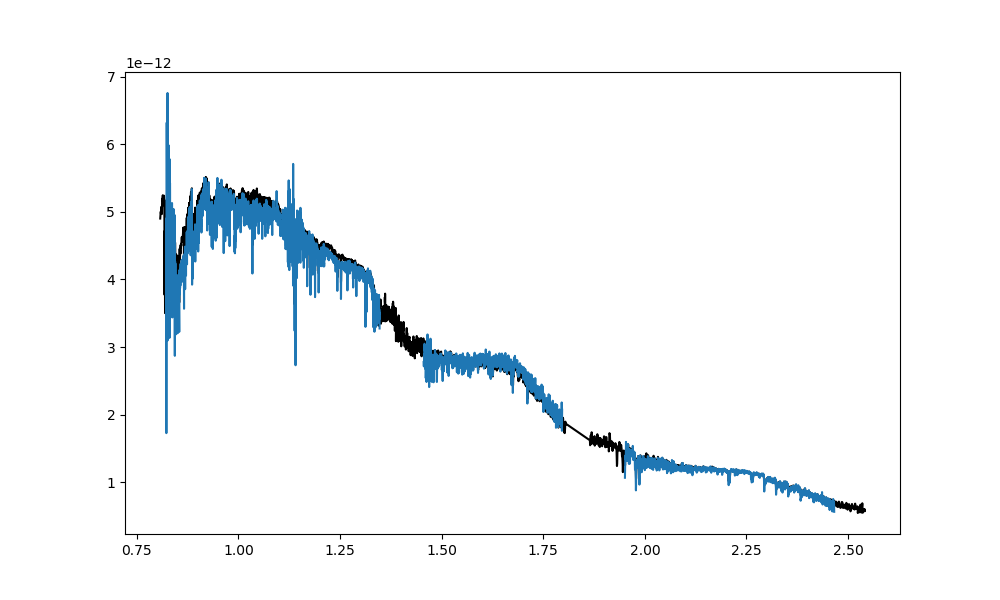

In [9]:
plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum_M4V.short_wavelength, template_spectrum_M4V.short_flux_density,'k',label='Gl 213')
plt.plot(awi0005c5q_remerged.wav, awi0005c5q_remerged.flux_watts*4.4,label='AWI0005c5q')
plt.show()

<IPython.core.display.Javascript object>


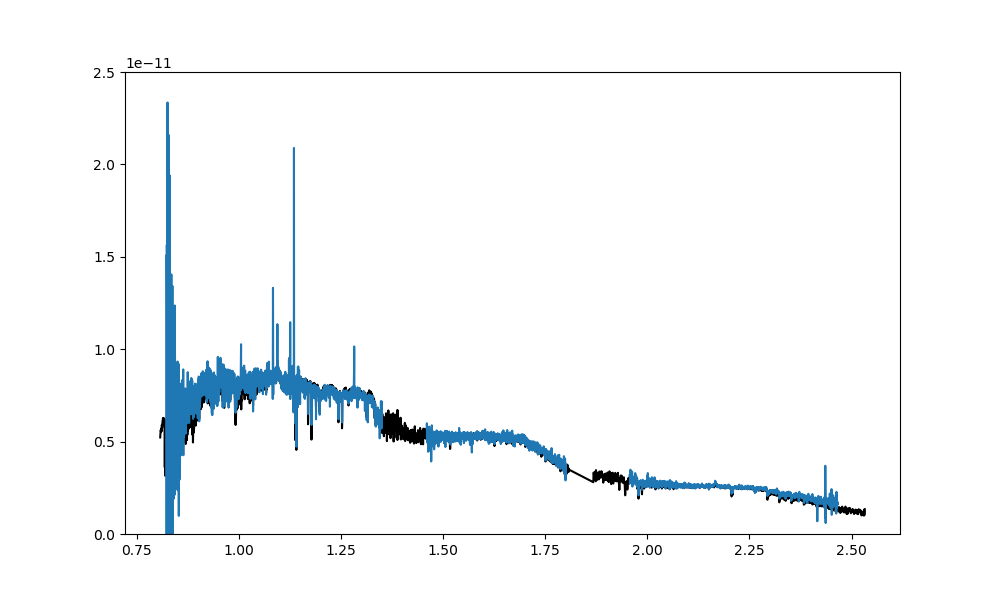

In [10]:
plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density,'k',label='Gl 213')
plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts*399.,label='AWI0005x3s')
plt.ylim([0.,2.5e-11])
plt.show()

In [ ]:
awi0005c5q_raw_orders = import_arcoiris_spectrum_from_file('AWI0005c5q','awi0005c5q_xtc_python.txt','2017-11-04')

In [ ]:
scale_factors_awi0005c5q = [0.96, 1., 1.07, 1.1, 1.1, 1.1]


plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum_M4V.short_wavelength, template_spectrum_M4V.short_flux_density/4.38,'k',label='Gl214')

ordercounter = 0
max_ordercounter = 2

for order in awi0005c5q_raw_orders.orderlist:
    if ordercounter > max_ordercounter:
        break
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 125.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 125.])
    
    plt.plot(wav_use, flux_use*scale_factors_awi0005c5q[ordercounter])
    ordercounter += 1

plt.show()

In [12]:
#awi0005x3s_20171104_remerged_wav_angstroms = awi0005x3s_20171104_remerged.wav * 10000.

#stellar radius in meters
rstar = 0.30 * 695700000.

#distance from trig. parallax, in meters
dstar = (1000./9.8599) * 3.08567758149137e16

rdstar = (rstar**2)/(dstar**2)

print rdstar

Tdisk = 1071.
Tstar = 3050.

Tratio = (Tdisk/Tstar)**4

print Tratio

max_xdisk = 0.11 / Tratio * rdstar

print max_xdisk

bestfit_xdisk = 0.054 / Tratio * rdstar

print bestfit_xdisk

test_xdisk = 0.10 /Tratio * rdstar

template_wav_angstroms = template_spectrum.short_wavelength * 10000.

awi0005x3s_20171104_2mass_merged_blackbody = blackbody_lambda(wav_20171104_2mass_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20171104_2mass_angstroms_trunclong = np.array([x for x in wav_20171104_2mass_angstroms if x > (2.285e4)])
awi0005x3s_20171104_2mass_merged_blackbody_trunclong = blackbody_lambda(wav_20171104_2mass_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict = {wav_20171104_2mass_angstroms_trunclong[i]: awi0005x3s_20171104_2mass_merged_blackbody_trunclong[i] for i in range(awi0005x3s_20171104_2mass_merged_blackbody_trunclong.size)}

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting = np.zeros(wav_20171104_2mass_angstroms.size)
for i in range(wav_20171104_2mass_angstroms.size):
    if wav_20171104_2mass_angstroms[i] > 2.285e4:
        awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting[i] = awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict[wav_20171104_2mass_angstroms[i]]

template_wav_angstroms_trunclong = np.array([x for x in template_wav_angstroms if x > (2.285e4)])
template_blackbody_trunclong = blackbody_lambda(template_wav_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

template_blackbody_trunclong_dict = {template_wav_angstroms_trunclong[i]: template_blackbody_trunclong[i] for i in range(template_blackbody_trunclong.size)}

template_blackbody_trunclong_plotting = np.zeros(template_wav_angstroms.size)
for i in range(template_wav_angstroms.size):
    if template_wav_angstroms[i] > 2.285e4:
        template_blackbody_trunclong_plotting[i] = template_blackbody_trunclong_dict[template_wav_angstroms[i]]


print max(awi0005x3s_20171104_2mass_merged_blackbody)

4.44764838653e-21
0.015204023281
3.21784118241e-20
1.57966748955e-20
5.18550045273e-16


In [13]:
test_xdisk_20180301 = 0.11 / Tratio * rdstar

awi0005x3s_20180301_blackbody = blackbody_lambda(wav_20180301_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180301_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180301_angstroms_trunclong = np.array([x for x in wav_20180301_angstroms if x > (2.285e4)])
awi0005x3s_20180301_blackbody_trunclong = blackbody_lambda(wav_20180301_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180301_blackbody_trunclong_dict = {wav_20180301_angstroms_trunclong[i]: awi0005x3s_20180301_blackbody_trunclong[i] for i in range(awi0005x3s_20180301_blackbody_trunclong.size)}

awi0005x3s_20180301_blackbody_trunclong_plotting = np.zeros(wav_20180301_angstroms.size)
for i in range(wav_20180301_angstroms.size):
    if wav_20180301_angstroms[i] > 2.285e4:
        awi0005x3s_20180301_blackbody_trunclong_plotting[i] = awi0005x3s_20180301_blackbody_trunclong_dict[wav_20180301_angstroms[i]]

In [14]:
test_xdisk_20180302 = 0.09 / Tratio * rdstar

awi0005x3s_20180302_blackbody = blackbody_lambda(wav_20180302_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180302_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180302_angstroms_trunclong = np.array([x for x in wav_20180302_angstroms if x > (2.285e4)])
awi0005x3s_20180302_blackbody_trunclong = blackbody_lambda(wav_20180302_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180302_blackbody_trunclong_dict = {wav_20180302_angstroms_trunclong[i]: awi0005x3s_20180302_blackbody_trunclong[i] for i in range(awi0005x3s_20180302_blackbody_trunclong.size)}

awi0005x3s_20180302_blackbody_trunclong_plotting = np.zeros(wav_20180302_angstroms.size)
for i in range(wav_20180302_angstroms.size):
    if wav_20180302_angstroms[i] > 2.285e4:
        awi0005x3s_20180302_blackbody_trunclong_plotting[i] = awi0005x3s_20180302_blackbody_trunclong_dict[wav_20180302_angstroms[i]]

<IPython.core.display.Javascript object>


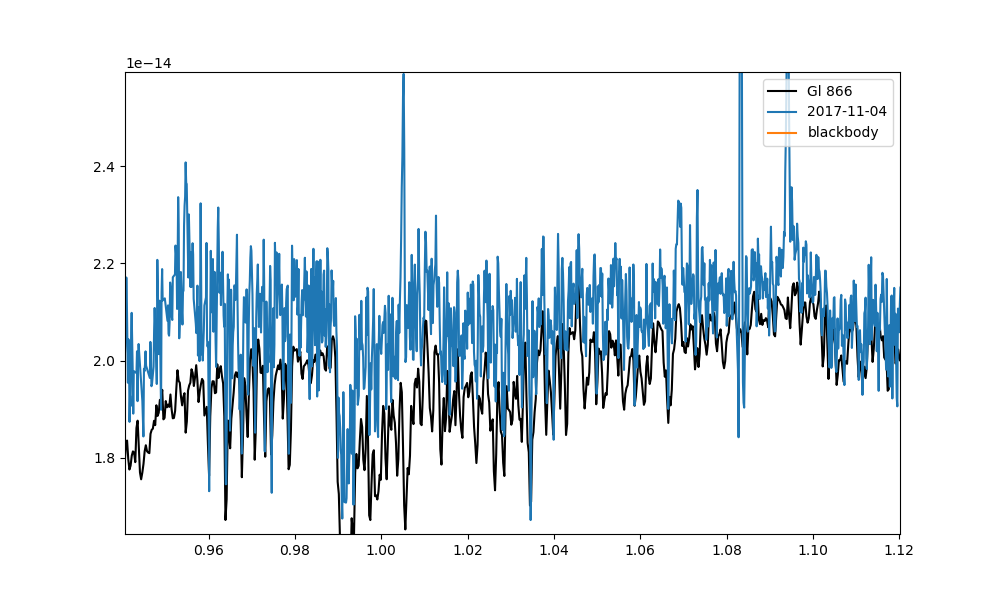

<IPython.core.display.Javascript object>


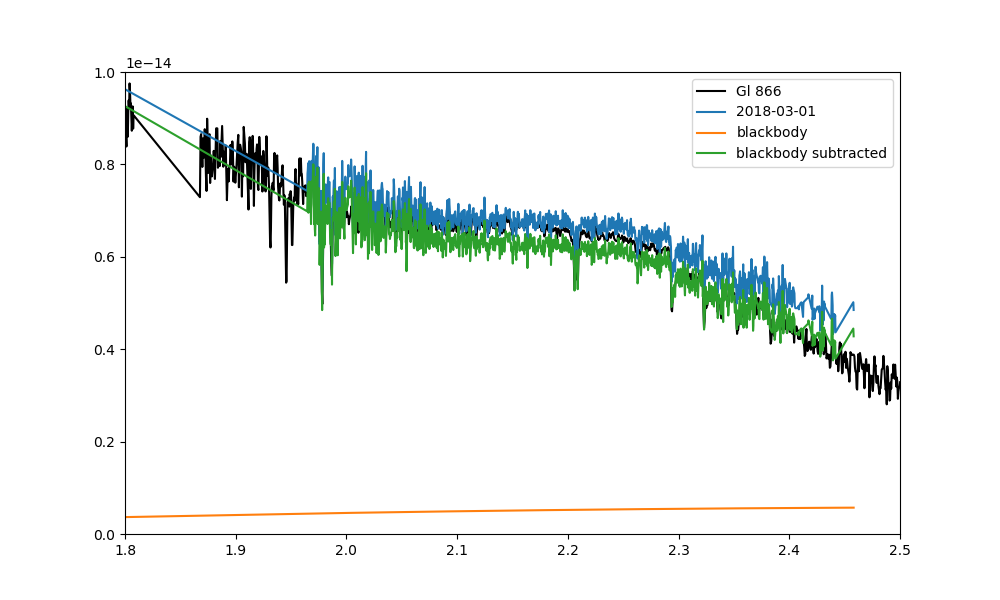

<IPython.core.display.Javascript object>


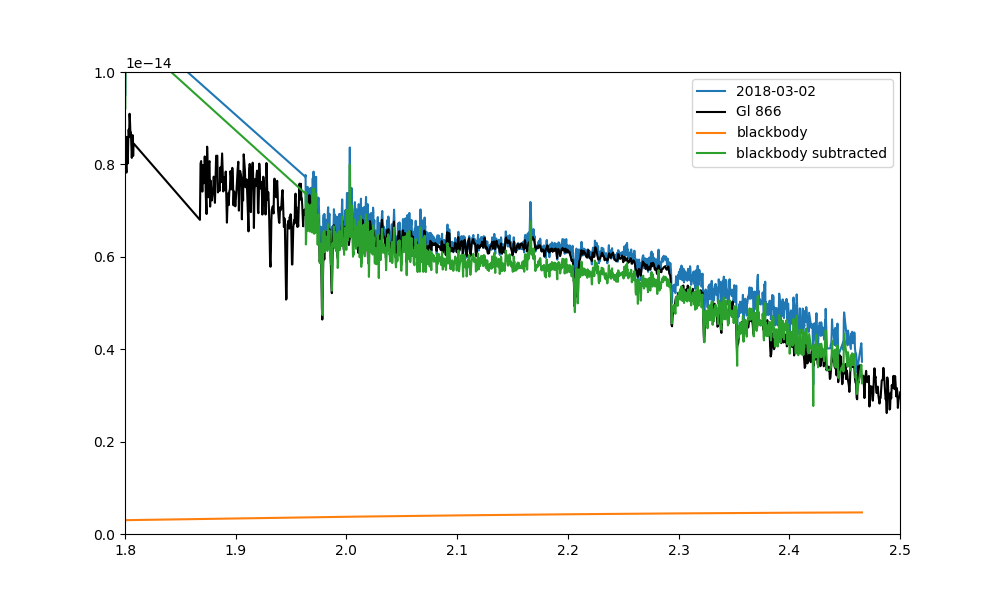

In [28]:
plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
#plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts,label='2018-03-01')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180301_highsnr_wav, awi0005x3s_20180301_highsnr_flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts,label='2018-03-02')
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180302_highsnr_wav, awi0005x3s_20180302_highsnr_flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts - awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody_trunclong_plotting)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts,label='AWI0005x3s')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged_blackbody)
#plt.ylim([1.0e-16,1.0e-13])
#plt.yscale('log',nonposy='clip')
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts - awi0005x3s_20171104_remerged_blackbody, label='AWI0005x3s blackbody subtracted')
#plt.ylim([0.,6.0e-14])
#plt.show()

<IPython.core.display.Javascript object>


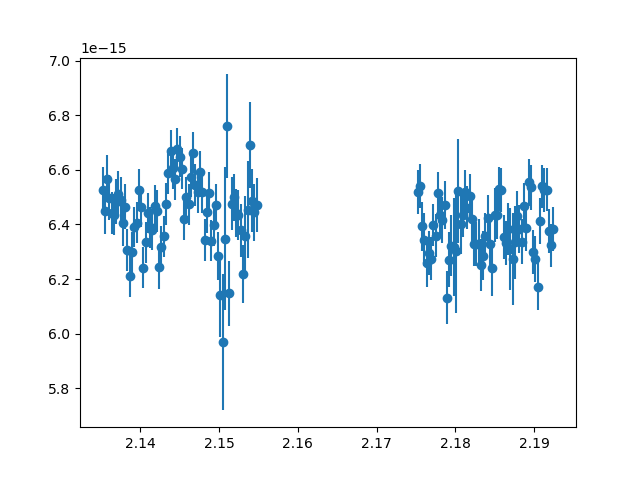

<IPython.core.display.Javascript object>


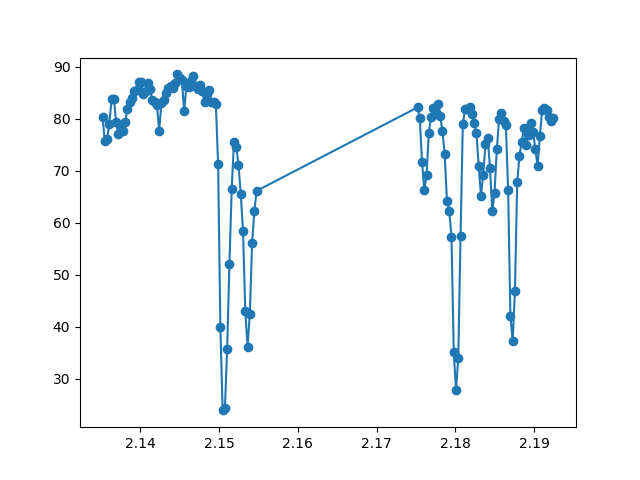

In [16]:
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.135 and x <2.155) or (x>2.175 and x<2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux = np.array([awi0005x3s_20171104_2mass_highsnr_flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err = np.array([awi0005x3s_20171104_2mass_highsnr_err[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.135 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.155) or (awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.175 and awi0005x3s_20171104_2mass_highsnr_wav[i] <2.1925))])

plt.figure()
plt.errorbar(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux,yerr=awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,fmt='o')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err,'o-')
plt.show()


In [17]:
m_nonweighted, c_nonweighted, r_value, p_value, std_err = linregress(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux)
print m_nonweighted, c_nonweighted, r_value

-1.39899888508e-15 9.44343361824e-15 -0.226217797587


In [18]:
def lnlike_cont(theta, x, y, yerr):
    m1, m2, lnb = theta
    
    m = m1*(10**m2)
    
    model = m*x + np.exp(lnb)
    
    #print model
    
    inv_sigma2 = 1.0/(yerr**2)
    
    res = -0.5*(np.sum((((y-model)**2)*inv_sigma2) - np.log(inv_sigma2)))
    #print res
    
    return -0.5*(np.sum((((y-model)**2)*inv_sigma2) - np.log(inv_sigma2)))
    
nll = lambda *args: -lnlike_cont(*args)

result = minimize(nll, [-1., -15, np.log(6.4e-15)], args=(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err))

m1_res, m2_res, lnb_res = result["x"]

print m1_res, m2_res, lnb_res

print m1_res * (10**m2_res), np.exp(lnb_res)

-2.37107528565 -15.2630744663 -32.3168473395
-1.29381111397e-15 9.22510945996e-15


<IPython.core.display.Javascript object>


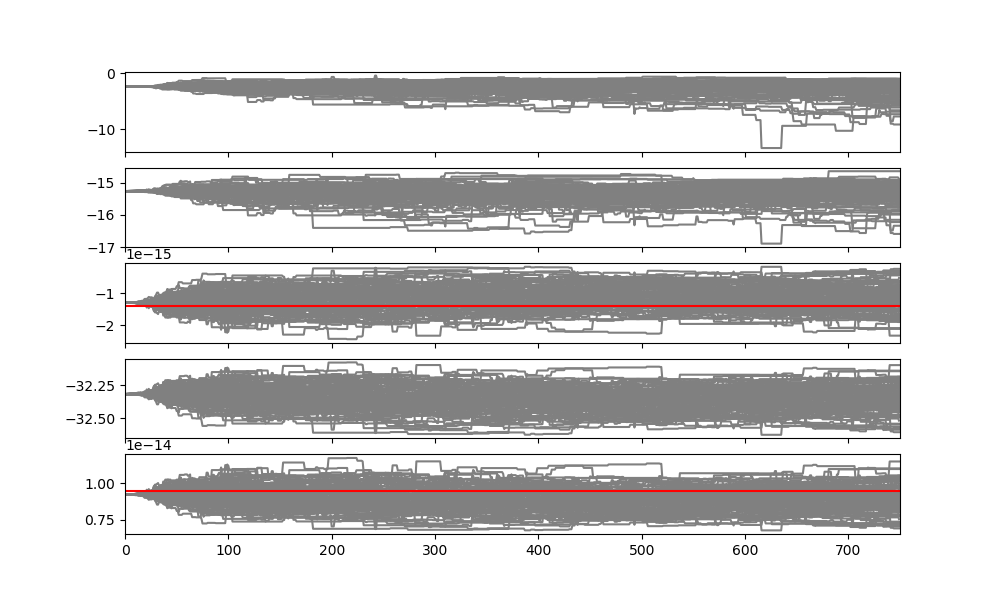

In [19]:
def lnprior_cont(theta):
    m1, m2, lnb = theta
    if lnb < 0.:
        return 0.0
    return -np.inf

def lnprob_cont(theta, x, y, yerr):
    lp = lnprior_cont(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_cont(theta, x, y, yerr)

ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cont, args=(awi0005x3s_20171104_2mass_highsnr_brgamma_cont_x, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_err))
sampler.run_mcmc(pos, 750)

fig, axarr1 = plt.subplots(5,sharex=True,figsize=(10.,6.))
dummy_ones = np.ones(750)
for i in range(100):
    axarr1[0].plot(np.linspace(0,749,750),sampler.chain[i,:,0],'grey')
    axarr1[1].plot(np.linspace(0,749,750),sampler.chain[i,:,1],'grey')
    axarr1[2].plot(np.linspace(0,749,750),(sampler.chain[i,:,0] * (10.**sampler.chain[i,:,1])),'grey')
    axarr1[3].plot(np.linspace(0,749,750),sampler.chain[i,:,2],'grey')
    axarr1[4].plot(np.linspace(0,749,750), np.exp(sampler.chain[i,:,2]),'grey')
    

axarr1[2].plot(np.linspace(0,749,750),(dummy_ones*m_nonweighted),'red')
axarr1[4].plot(np.linspace(0,749,750),(dummy_ones*c_nonweighted),'red')

plt.xlim([0.,750.])
plt.show()

winsound.Beep(440,1500)

In [20]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

print samples.shape

sample_results = np.zeros((samples.shape[0],2))

print sample_results.shape

#print sample_results.shape
sample_results[:,0] = samples[:,0] * (10.**samples[:,1])
sample_results[:,1] = np.exp(samples[:,2])

#fig = corner.corner(samples, labels=["$m1$", "$m2$", "$\ln\b$"],truths=[m1_res, m2_res, lnb_res])
#plt.show()

#fig1 = corner.corner(sample_results, labels=["$m$","$b$"],truths=[m_nonweighted, c_nonweighted])
#plt.show()

m_mcmc_brgamma_20171104, b_mcmc_brgamma_20171104 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(sample_results, [16, 50, 84], axis=0)))

print m_mcmc_brgamma_20171104, b_mcmc_brgamma_20171104

(60000L, 3L)
(60000L, 2L)
(-1.1438591431972203e-15, 4.0175698589667107e-16, 4.0733572936518017e-16) (8.9014890844750032e-15, 8.7931233092406462e-16, 8.717072950989072e-16)


In [26]:
awi0005x3s_20171104_2mass_highsnr_brgamma_contwav = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.135 and x < 2.1925))])

print awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size

cont_ests = np.zeros(sample_results[:,0].size)

print cont_ests.size

start_time = time.time()

for i in range(cont_ests.size):
    contflux = (sample_results[i,0]*awi0005x3s_20171104_2mass_highsnr_brgamma_contwav) + sample_results[i,1]
    
    cont_ests[i] = np.trapz(contflux, x=awi0005x3s_20171104_2mass_highsnr_brgamma_contwav) * (awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[-1] - awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[0])
    
    #if i%100 < 1:
    #    print i, time.time() - start_time, ((time.time() - start_time) * (cont_ests.size - i))/60.

print np.percentile(cont_ests,50), np.percentile(cont_ests,84) - np.percentile(cont_ests,50), np.percentile(cont_ests,50) - np.percentile(cont_ests,16)
print (np.percentile(cont_ests,84) - np.percentile(cont_ests,50))/np.percentile(cont_ests,50), (np.percentile(cont_ests,50) - np.percentile(cont_ests,16))/np.percentile(cont_ests,50)
winsound.Beep(440,1000)

200
60000
2.10730934126e-17 2.39691805859e-20 2.41166865285e-20
0.00113743056686 0.00114443029584


<IPython.core.display.Javascript object>


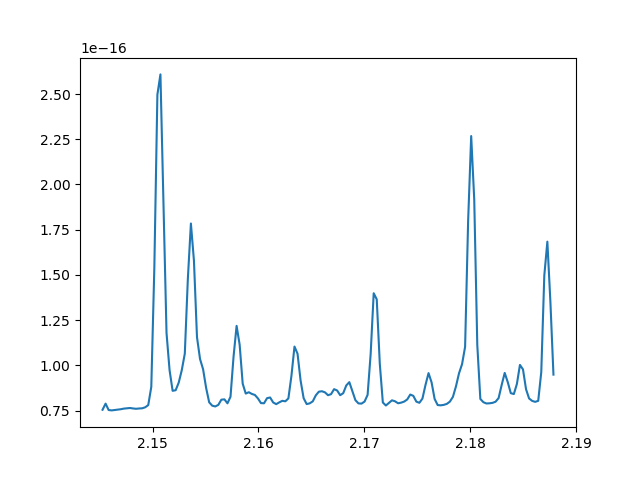

<IPython.core.display.Javascript object>


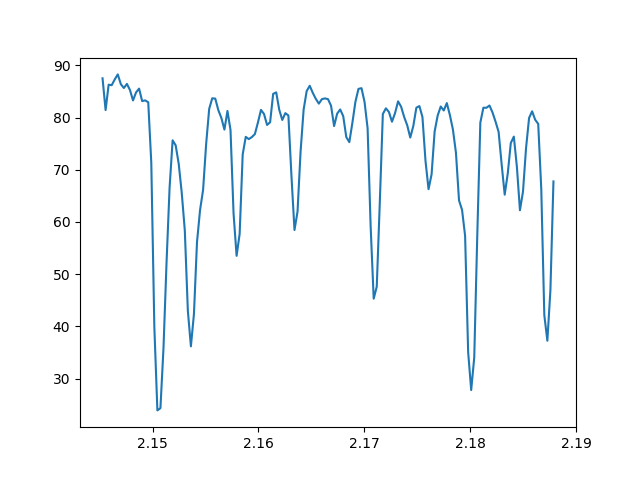

<IPython.core.display.Javascript object>


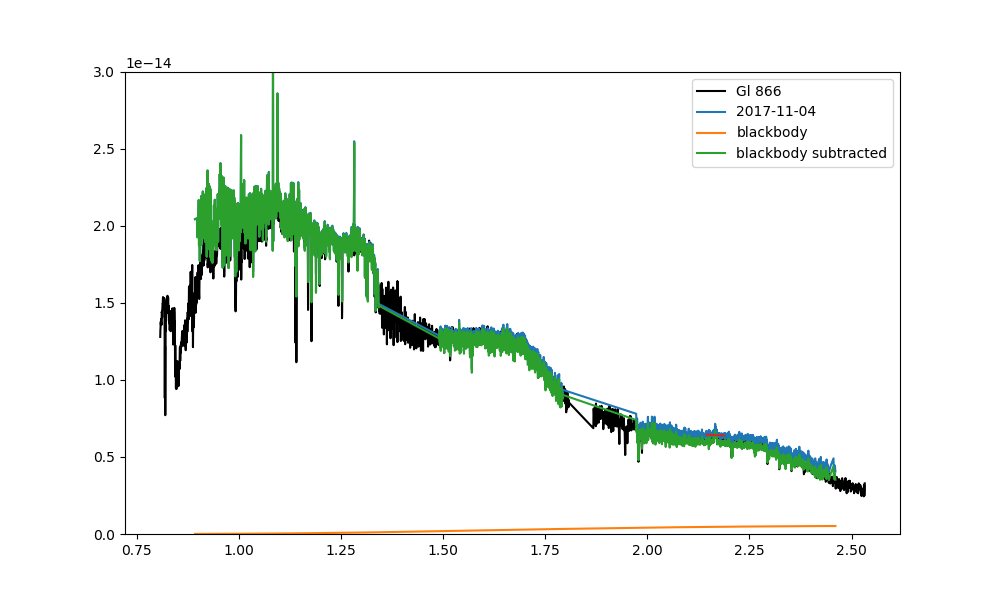

<IPython.core.display.Javascript object>


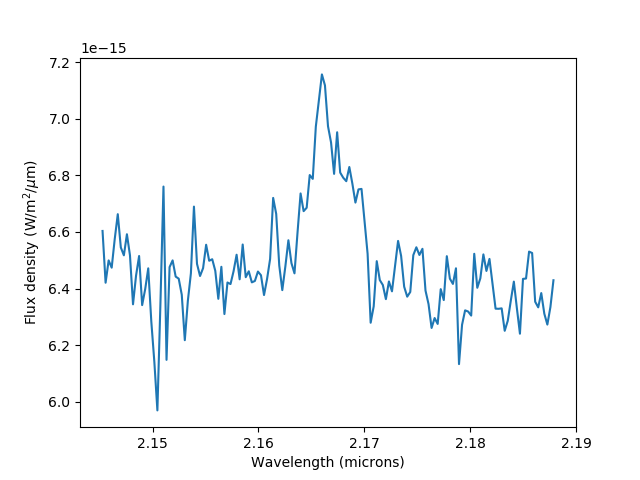

<IPython.core.display.Javascript object>


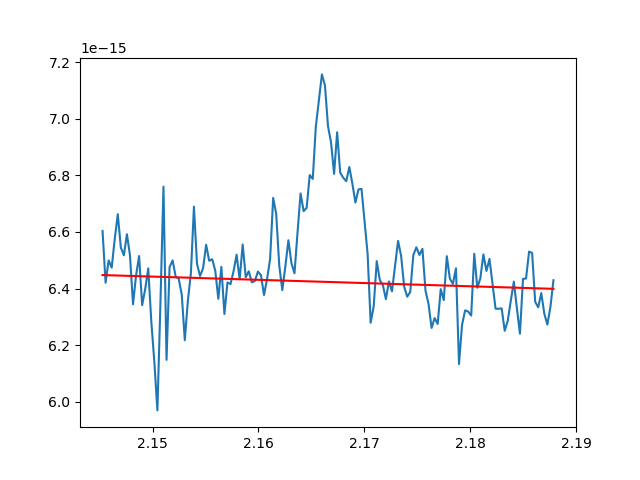

<IPython.core.display.Javascript object>


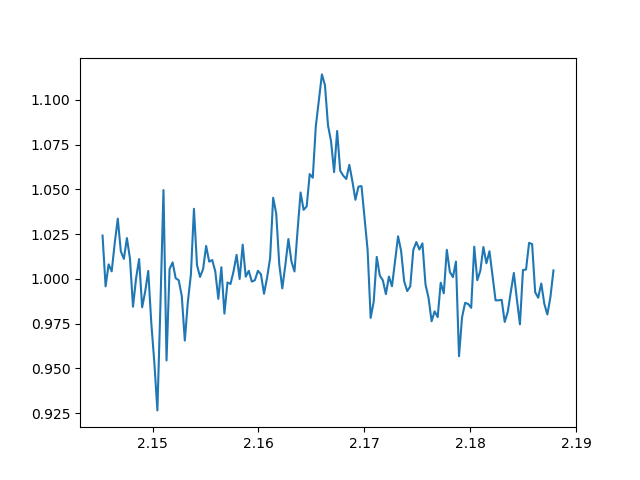

149
-0.000487611681394 6.14432454715e-07 6.12043736927e-07
-0.00126008559302 -0.00125518678137


In [32]:
awi0005x3s_20171104_2mass_highsnr_brgamma_flux = np.array([awi0005x3s_20171104_2mass_highsnr_flux_watts[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.145) and (awi0005x3s_20171104_2mass_highsnr_wav[i] <2.188))])
awi0005x3s_20171104_2mass_highsnr_brgamma_err = np.array([awi0005x3s_20171104_2mass_highsnr_err[i] for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size) if ((awi0005x3s_20171104_2mass_highsnr_wav[i] > 2.145) and (awi0005x3s_20171104_2mass_highsnr_wav[i] <2.188))])

awi0005x3s_20171104_2mass_highsnr_brgamma_contwav = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_wav if ((x > 2.145 and x < 2.188))])
awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line = (m_mcmc_brgamma_20171104[0] * awi0005x3s_20171104_2mass_highsnr_brgamma_contwav) + b_mcmc_brgamma_20171104[0]

awi0005x3s_20171104_2mass_highsnr_brgamma_snr = awi0005x3s_20171104_2mass_highsnr_brgamma_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_err

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_err)
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_snr)
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line)
plt.ylim([0.,3.0e-14])
#plt.xlim([1.8,2.5])
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_flux)
plt.xlabel("Wavelength (microns)")
plt.ylabel(r"Flux density (W/m$^2$/$\mu$m)")
#plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line,'r')
plt.savefig('awi0005x3s_20171104_2mass_highsnr_brgamma.png')

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_flux)
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line,'r')
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav, awi0005x3s_20171104_2mass_highsnr_brgamma_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line)
plt.show()

brgamma_eqwidth_20171104 = np.zeros(sample_results[:,0].size)
brgamma_avg_contflux_20171104 = np.zeros(sample_results[:,0].size)
brgamma_lineflux_20171104 = np.zeros(sample_results[:,0].size)


print awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size

error_test_one = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size)
error_test_two = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size)

val = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size)

for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size):
    cont_est_center_samples = (sample_results[:,0] * awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[100]) + sample_results[:,1]

    cont_est_center = np.percentile(cont_est_center_samples, 50)
    cont_est_center_low = np.percentile(cont_est_center_samples, 16)
    cont_est_center_high = np.percentile(cont_est_center_samples, 84)

    cont_est_use = max((cont_est_center-cont_est_center_low), (cont_est_center_high - cont_est_center))
    
    val[i] = 1. - (awi0005x3s_20171104_2mass_highsnr_brgamma_flux[i] / cont_est_center)
    
    error_test_one[i] = np.sqrt(((cont_est_use/cont_est_center)**2) + ((awi0005x3s_20171104_2mass_highsnr_brgamma_err[i]/awi0005x3s_20171104_2mass_highsnr_brgamma_flux[i])**2)) * val[i]
    
    error_test_two[i] = (awi0005x3s_20171104_2mass_highsnr_brgamma_err[i]/awi0005x3s_20171104_2mass_highsnr_brgamma_flux[i]) * val[i]
    
res = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size - 1)
res_errs_one = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size - 1)
res_errs_two = np.zeros(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size - 1)

for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size - 1):
    res[i] = 0.5*(val[i+1] + val[i])*(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[i+1] - awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[i])
    res_errs_one[i] = 0.5*(np.sqrt(((error_test_one[i+1])**2) + ((error_test_one[i])**2))/(val[i+1] + val[i])) * res[i]
    res_errs_two[i] = 0.5*(np.sqrt(((error_test_two[i+1])**2) + ((error_test_two[i])**2))/(val[i+1] + val[i])) * res[i]
    
sumres = np.sum(res)
res_errs_one_quad = (res_errs_one)**2
res_errs_one_quad_sum = np.sum(res_errs_one_quad)
sumres_errs_one = res_errs_one_quad_sum ** 0.5

#print res_errs_one_quad.shape
#print res_errs_one_quad.shape


res_errs_two_quad = (res_errs_two)**2
res_errs_two_quad_sum = np.sum(res_errs_two_quad)
sumres_errs_two = res_errs_two_quad_sum ** 0.5

print sumres, sumres_errs_one, sumres_errs_two
print sumres_errs_one/sumres, sumres_errs_two/sumres

#print cont_est_center, (cont_est_center - cont_est_center_low)/cont_est_center, (cont_est_center_high - cont_est_center)/cont_est_center
#print awi0005x3s_20171104_2mass_highsnr_brgamma_flux[100], awi0005x3s_20171104_2mass_highsnr_brgamma_err[100]/awi0005x3s_20171104_2mass_highsnr_brgamma_flux[100]

#print np.sqrt((((cont_est_center - cont_est_center_low)/cont_est_center)**2) + ((awi0005x3s_20171104_2mass_highsnr_brgamma_err[100]/awi0005x3s_20171104_2mass_highsnr_brgamma_flux[100])**2))


In [ ]:
for i in sample_results[:,0].size:
    awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line_use = (sample_results[i,0] * awi0005x3s_20171104_2mass_highsnr_brgamma_contwav) + sample_results[:,1]    
    brgamma_flux_normalized_20171104 = awi0005x3s_20171104_2mass_highsnr_brgamma_flux/awi0005x3s_20171104_2mass_highsnr_brgamma_cont_flux_line_use
    brgamma_err_normalized_20171104 = [((awi0005x3s_20171104_2mass_highsnr_brgamma_err/awi0005x3s_20171104_2mass_highsnr_brgamma_flux[i])**2)

    brgamma_line_wav_20171104 = np.array([x for x in awi0005x3s_20171104_2mass_highsnr_brgamma_contwav if (x > 2.1625 and x < 2.171)])
    brgamma_line_flux_normalized_20171104 = np.array([brgamma_flux_normalized_20171104[i] for i in range(awi0005x3s_20171104_2mass_highsnr_brgamma_contwav.size) if (awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[i] > 2.1625 and awi0005x3s_20171104_2mass_highsnr_brgamma_contwav[i] < 2.171)])

    brgamma_line_err_normalized_20171104 = 

    brgamma_eqwidth_20171104[i] = np.trapz(1. - brgamma_line_flux_normalized_20171104, x=brgamma_line_wav_20171104)


print brgamma_eqwidth_20171104 * 10000.

In [125]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict


In [126]:
teffpull = '0'+str(int(3100./100))
loggpull = str(4.5)

spect_file = '../../BTSettlstuff_use/BT-Settl_M-0.0a+0.0/lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)

In [159]:
print max(spec_X)

spec_X_microns = spec_X / 10000.

print max(spec_X_microns)

spec_S_20171104_firsttry = np.interp(awi0005x3s_20171104_2mass_highsnr_wav, spec_X_microns, spec_S*10.) * rdstar

spec_S_20171104_secondtry = np.zeros(awi0005x3s_20171104_2mass_highsnr_wav.size)

inner_binbounds = [(awi0005x3s_20171104_2mass_highsnr_wav[i] + awi0005x3s_20171104_2mass_highsnr_wav[i+1])/2 for i in range(awi0005x3s_20171104_2mass_highsnr_wav.size - 1)]
    
binbounds = [awi0005x3s_20171104_2mass_highsnr_wav[0] - (inner_binbounds[0] - awi0005x3s_20171104_2mass_highsnr_wav[0])]

for bound in inner_binbounds:
    binbounds.append(bound)
    
binbounds.append(awi0005x3s_20171104_2mass_highsnr_wav[-1] + (awi0005x3s_20171104_2mass_highsnr_wav[-1] - inner_binbounds[-1]))

binbounds_use = np.array(binbounds)

print min(awi0005x3s_20171104_2mass_highsnr_wav), max(awi0005x3s_20171104_2mass_highsnr_wav)
print min(binbounds_use), max(binbounds_use)

print "Done"

9995000.0
999.5
0.892534375191 2.46037983894
0.889872014523 2.46095538139
Done


In [162]:
spec_S_of_concern = np.array([spec_S[i] for i in range(spec_X_microns.size) if (spec_X_microns[i] > 0.88) and (spec_X_microns[i] < 2.47)])
spec_X_microns_of_concern = np.array([x for x in spec_X_microns if (x>0.88) and (x<2.47)])

spec_dict_of_concern = {spec_X_microns_of_concern[i]: spec_S_of_concern[i] for i in range(spec_X_microns_of_concern.size)}

In [174]:
import time

print spec_S_20171104_secondtry.size

start_time = time.time()

ivec = np.zeros(binbounds_use.size - 1)
ratevec = np.zeros(ivec.size)
exp_total_time_vec = np.zeros(ivec.size)
for i in range(binbounds_use.size - 1):
    lower = binbounds_use[i]
    upper = binbounds_use[i+1]
    wavs = [x for x in spec_dict_of_concern.keys() if (x < upper) and (x > lower)]
    vals = [spec_dict_of_concern[x] for x in wavs]
    
    spec_S_20171104_secondtry[i] = np.trapz(vals, x=wavs)/(upper-lower)
    cycle_time = time.time()
    
    ivec[i] = (i)
    
    ratevec[i] = ((cycle_time - start_time)/float(i+1))
    exp_total_time_vec[i] = ((cycle_time - start_time)) + ((ratevec[i]) * (spec_S_20171104_secondtry.size - i + 1))
    
    if (i%100) < 1:
        print i, cycle_time - start_time, ratevec[i], (ratevec[i] * (spec_S_20171104_secondtry.size - i + 1))/60.
        
print "Done"

5802
0 0.138000011444 0.138000011444 13.3469011068
100 11.1740000248 0.110633663612 10.5157297263
200 21.9879999161 0.109393034408 10.2154861965
300 32.867000103 0.109192691372 10.014789677
400 43.8399999142 0.109326683078 9.84486781115
500 55.0840001106 0.109948104013 9.71757992637
600 66.2460000515 0.110226289603 9.55845641342
700 77.4930000305 0.110546362383 9.40196812068
800 88.9270000458 0.111019975088 9.25721558945
900 100.210000038 0.111220865747 9.08859841263
1000 111.615999937 0.111504495442 8.9259348601
1100 123.217999935 0.111914623011 8.77224120035
1200 134.648000002 0.112113238969 8.60095398291
1300 146.256000042 0.112418139925 8.43698140134
1400 158.174999952 0.112901498895 8.28508832727
1500 169.877000093 0.113175882807 8.11659706198
1600 181.730000019 0.113510306071 7.95139694025
1700 193.749000072 0.113902998279 7.78906669897
1800 205.879999876 0.114314269781 7.62666703224
1900 217.828999996 0.114586533401 7.45385399777
2000 229.957999945 0.114921539203 7.28411022647
2

<IPython.core.display.Javascript object>


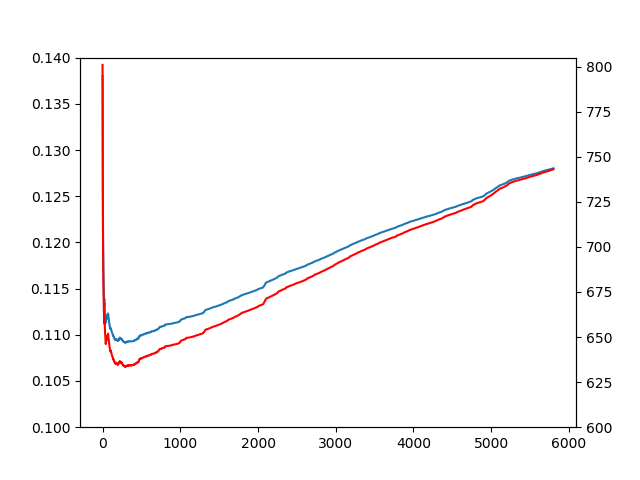

800.952066422
0.138000011444


In [185]:
fig, ax1 = plt.subplots()
ax1.plot(ivec,ratevec)
ax1.set_ylim([0.1,0.14])

ax2 = ax1.twinx()
ax2.plot(ivec,exp_total_time_vec,'r')
ax2.set_ylim([600.,805.])

print max(exp_total_time_vec)
print max(ratevec)

plt.show()

<IPython.core.display.Javascript object>


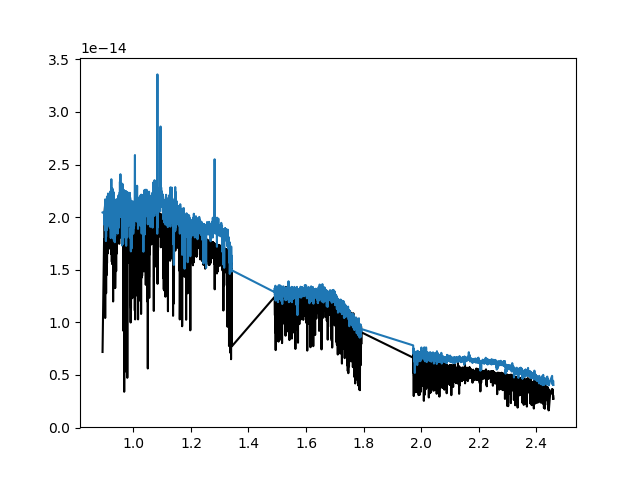

-813360.540566 1248567.02358


<IPython.core.display.Javascript object>


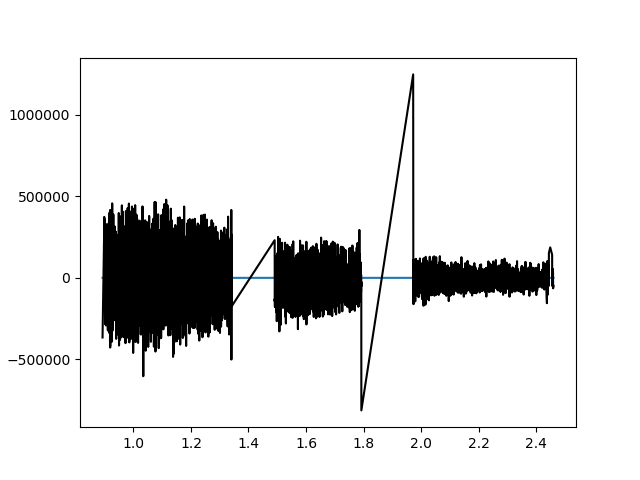

In [187]:
plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, spec_S_20171104_firsttry, 'k', label='M5V')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.show()

print min(spec_S_20171104_secondtry), max(spec_S_20171104_secondtry)

plt.figure()
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, awi0005x3s_20171104_2mass_highsnr_flux_watts,label='2017-11-04')
plt.plot(awi0005x3s_20171104_2mass_highsnr_wav, spec_S_20171104_secondtry, 'k', label='M5V')
plt.show()

In [ ]:
def insort(a, b, kind='mergesort'):
    # took mergesort as it seemed a tiny bit faster for my sorted large array try.
    c = np.concatenate((a, b)) # we still need to do this unfortunatly.
    c.sort(kind=kind)
    flag = np.ones(len(c), dtype=bool)
    np.not_equal(c[1:], c[:-1], out=flag[1:])
    return c[flag]

In [ ]:
combined_grid = np.array([x for x in insort(template_spectrum.short_wavelength, awi0005x3s_20171104_remerged.wav) if ((x > min(awi0005x3s_20171104_remerged.wav)) and (x < max(awi0005x3s_20171104_remerged.wav)))])
combined_grid_angstroms = combined_grid * 10000.

awi0005x3s_20171104_remerged_interpolated = np.interp(combined_grid, awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts)
template_spectrum_interpolated = np.interp(combined_grid, template_spectrum.short_wavelength, template_spectrum.short_flux_density)

blackbody_interpolated = blackbody_lambda(combined_grid, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

plt.figure(figsize=(10.,6.))
plt.plot(combined_grid,template_spectrum_interpolated/399., 'k',label='Gl 866')
plt.plot(combined_grid, awi0005x3s_20171104_remerged_interpolated, label='AWI0005x3s')
plt.plot(combined_grid, blackbody_interpolated)
plt.ylim([0.,])
plt.xlabel(r'Wavelength ($\mu$m)', fontsize=18)
plt.ylabel(r'Flux (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=18)
plt.show()

#print combined_grid[-500]
print awi0005x3s_20171104_remerged.wav[-500]
print max(awi0005x3s_20171104_remerged.err_watts[-1000:])
print max(awi0005x3s_20171104_remerged.err_watts[-1000:]/awi0005x3s_20171104_remerged.flux_watts[-1000:])

In [ ]:
awi0005x3s_20171104_wav_highsnr, awi0005x3s_20171104_flux_highsnr, awi0005x3s_20171104_err_highsnr = awi0005x3s_20171104_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180301_wav_highsnr, awi0005x3s_20180301_flux_highsnr, awi0005x3s_20180301_err_highsnr = awi0005x3s_20180301_remerged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180302_wav_highsnr, awi0005x3s_20180302_flux_highsnr, awi0005x3s_20180302_err_highsnr = awi0005x3s_20180302_remerged.get_snr_cut_spectrum_watts(20.)

plt.figure(figsize=(10.,6.))
plt.plot(combined_grid,template_spectrum_interpolated/399., 'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_wav_highsnr, awi0005x3s_20171104_flux_highsnr, label='2017-11-04')
plt.plot(awi0005x3s_20180301_wav_highsnr, awi0005x3s_20180301_flux_highsnr, label='2018-03-01')
plt.plot(awi0005x3s_20180302_wav_highsnr, awi0005x3s_20180302_flux_highsnr, label='2018-03-02')
#plt.plot(combined_grid, blackbody_interpolated)
plt.ylim([0.,6.0e-14])
plt.xlabel(r'Wavelength ($\mu$m)', fontsize=18)
plt.ylabel(r'Flux (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=18)
plt.show()